In [14]:
import sghmcmc
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import random
from scipy.stats import norm

In [3]:
random.seed(1234)

## Example 1

In [4]:
def ut(theta):
    theta = np.array(theta)
    return 2 * (theta ** 2) - (theta ** 4)
def gut(theta):
    theta = np.array(theta)
    return 4 * theta - 4 * (theta ** 3)
def gutnoise(theta):
    theta = np.array(theta)
    return 4 * theta - 4 * (theta ** 3) + np.random.normal(0, 2)
mu = 0
sigma = 1
data = np.random.normal(mu, sigma, 1000)

In [6]:
C = 0
sghmc = sghmcmc.sghmc_jit(ut,gut,[0.0],C)
sghmc.sampling(50000,0.1,50,200)

In [7]:
C = 0 
naivesghmc = sghmcmc.naive_sghmc(ut, gutnoise, [2.0])
naivesghmc.sampling(50000, 0.1, 50, 200)

In [5]:
hmc = sghmcmc.hmc(ut, gutnoise, [2.0])
hmc.sampling(50000, 0.1, 50)

Text(0.5,1,'Comparison of different classifiers')

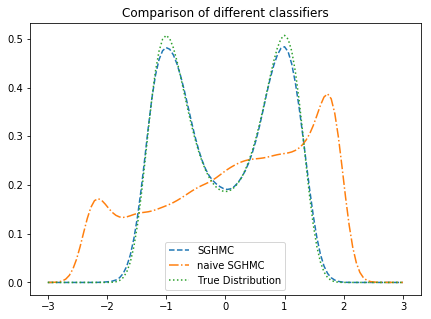

In [11]:
densitysghmc = stats.kde.gaussian_kde(np.array([x[0][0] for x in sghmc.res[100:]]))
densitynsghmc = stats.kde.gaussian_kde(np.array([x[0][0] for x in naivesghmc.res[100:]]))
densityhmc = stats.kde.gaussian_kde(np.array([x[0][0] for x in hmc.res[100:]]))
x = np.linspace(-3,3,100)
plt.figure(figsize=(7,5))
plt.plot(x, densitysghmc(x), '--',label = "SGHMC")
plt.plot(x, densitynsghmc(x), '-.', label = "naive SGHMC")
plt.plot(x, np.exp(ut(x))/5.361, ':',label = "True Distribution")
plt.legend()
plt.title("Comparison of different classifiers")

## Example 2

In [12]:
mu = 0
sigma = 1
data1 = np.random.normal(mu, sigma, 1000)
def lnp(x, theta):
    xn = np.array(x)
    t = np.array(theta)
    return norm.logpdf(xn, t, sigma)
def lnpgrad(x, theta):
    xn = np.array(x)
    t = np.array(theta)
    return (xn - t) / (sigma ** 2)

In [ ]:
t1 = sghmcmc.hmc(lnp, lnpgrad, [2], data, True)
t1.sampling(1000, 0.1, 5)
t2 = sghmcmc.sghmc_jit(lnp, lnpgrad, [2], C = 0, data = data, usedata = True)
t2.sampling(1000, 0.1, 5, 200)
t3 = sghmcmc.naive_sghmc(lnp, lnpgrad, [2], data = data, usedata = True)
t3.sampling(1000, 0.1, 5, 200)

In [ ]:
t1d = stats.kde.gaussian_kde(np.array([x[0][0] for x in t1.res[10:]]))
t2d = stats.kde.gaussian_kde(np.array([x[0][0] for x in t2.res[10:]]))
t3d = stats.kde.gaussian_kde(np.array([x[0][0] for x in t3.res[10:]]))
xs = np.linspace(-3.5,3.5,100)
plt.figure(figsize=(7,5))
plt.plot(xs, t1d(xs), ':',label = "HMC")
plt.plot(xs, t2d(xs), '--',label = "SGHMC")
plt.plot(xs, t3d(xs), '-.', label = "naive SGHMC")
plt.plot(xs, stats.norm.pdf(xs), '-',label = "True Distribution")
plt.legend(fontsize=11)
plt.xlabel(r'$\mu$',fontsize=12)
plt.ylabel('Probability',fontsize=12)
plt.title("Comparison of Different Classifiers(Standard Normal)",fontsize=13);
plt.savefig('Comp.png',dpi=300)

## Real Life Example

In [ ]:
#load data 
data = []
for line in open('glucose.dat', 'r'):
    item = line.rstrip()
    data.append(int(item))

In [ ]:
def lnp(x, theta):
    xn = np.array(x)
    t = np.array(theta)
    return norm.logpdf(xn,t,30)+ norm.logpdf(t,120,15)
def lnpgrad(x, theta):
    xn = np.array(x)
    t = np.array(theta)
    return (xn - t) / (30 ** 2) + (t - 120) / (15 ** 2)

In [ ]:
C = 0
t2 = sghmcmc.sghmc_jit(lnp,lnpgrad,[115],C, data = data, usedata = True)
t2.sampling(500,0.1,5,200)

In [ ]:
def lnp2(x, theta):
    xn = np.array(x)
    t = np.array(theta)
    return norm.logpdf(xn,t,30)+ norm.logpdf(t,110,20)
def lnpgrad2(x, theta):
    xn = np.array(x)
    t = np.array(theta)
    return (xn - t) / (30 ** 2) + (t - 110) / (20**2)

In [ ]:
C = 0
t3 = sghmcmc.sghmc_jit(lnp2,lnpgrad2,[115],C, data = data, usedata = True)
t3.sampling(500,0.1,5,200)

In [ ]:
t4 = sghmcmc.hmc(lnp,lnpgrad,[115], data = data, usedata = True)
t4.sampling(500,0.1,5)

In [ ]:
t2d = stats.kde.gaussian_kde(np.array([x[0][0] for x in t2.res[1:]]))
t3d = stats.kde.gaussian_kde(np.array([x[0][0] for x in t3.res[1:]]))
t4d = stats.kde.gaussian_kde(np.array([x[0][0] for x in t4.res[1:]]))
x = np.linspace(90,130,200)
plt.plot(x, t2d(x), label = "Posterior with Prior N(120,15)")
plt.plot(x, t3d(x), label = "Posterior with Prior N(115,25)")
plt.plot(x, t4d(x), label = "Posterior with Prior N(110,20)")
plt.xlabel(r"$\theta$")
plt.ylabel("density")
plt.title("Posterior Estimation of Plasma Glucose Concentration")
plt.legend()
pass
plt.savefig('posterior.png',dpi=300)